In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack


# Load dataset

In [10]:
headers = ['text','id', 'subreddit', 'meta', 'time', 'author', 'ups', 'downs', 'authorlinkkarma', 'authorkarma', 'authorisgold']
# reddit.columns = headers

In [91]:
reddit = pd.read_csv('comments.csv', names= headers, date_parser=['time'])  # header=None

In [94]:
reddit.shape

(2726000, 11)

# Preprocess

In [137]:
reddit.isnull().sum()

text                  0
id                    0
subreddit             0
meta                  0
time                  0
author                0
ups                   0
downs                 0
authorlinkkarma       0
authorkarma           0
authorisgold       9314
dtype: int64

In [95]:
# delete comments with NaN text
reddit = reddit[reddit['text'].notna()]

A lot of comments are there but the text are deleted. We should get rid of those records as well:

In [124]:
reddit[reddit.authorisgold.isna()][:10]

,text,id,subreddit,meta,time,author,ups,downs,authorlinkkarma,authorkarma,authorisgold
39,[ deleted ],d028eod,worldnews,news,1.455651e+09,[deleted],-1.0,0.0,0.0,0.0,NaN
252,[ removed ],d02cx5w,worldnews,news,1.455657e+09,[deleted],1.0,0.0,0.0,0.0,NaN
264,those pundits do n't have eighth time .,d02okk5,politics,news,1.455674e+09,1blah1,1.0,0.0,0.0,0.0,NaN
265,people think trump is an idiot. they are wrong...,d02kj5o,politics,news,1.455668e+09,ntt2wtt,1.0,0.0,0.0,0.0,NaN
266,make no mistake. donald trump knows exactly wh...,d02k5ou,politics,news,1.455667e+09,fuckingoff,1.0,0.0,0.0,0.0,NaN
403,[ deleted ],d02brz5,worldnews,news,1.455655e+09,[deleted],0.0,0.0,0.0,0.0,NaN
411,[ deleted ],d024aa7,politics,news,1.455645e+09,[deleted],1.0,0.0,0.0,0.0,NaN
420,[ deleted ],d01xwhf,worldnews,news,1.455636e+09,[deleted],16.0,0.0,0.0,0.0,NaN
430,[ deleted ],d01nnv6,worldnews,news,1.455605e+09,[deleted],-65.0,0.0,0.0,0.0,NaN
441,[ deleted ],d022qbv,politics,news,1.455643e+09,[deleted],1.0,0.0,0.0,0.0,NaN


In [125]:
reddit = reddit[reddit.text.str.find('[deleted]')!= False]

Some other comments have non-void text but the text is actually empty. We should also get rid of them.

In [152]:
reddit = reddit[reddit.text.str.len() != 0]

In [98]:
# drop duplicates -- turns out that there are a lot of duplicated rows
reddit = reddit.drop_duplicates()

In [128]:
# NAs in authorlinkkarma and authorkarma are annoying duplicates! --> should simply delete them
reddit = reddit[reddit.authorlinkkarma.isna() == False]

In [133]:
# fill NA's in author is gold with 0
reddit['authorlinkkarma'].fillna(0, inplace=True)

# EDA

In [138]:
reddit.describe()

,time,ups,downs,authorlinkkarma,authorkarma,authorisgold
count,9.792100e+04,97921.000000,97921.0,9.792100e+04,9.792100e+04,88607.000000
mean,1.455394e+09,53.915646,0.0,5.128443e+03,1.755740e+04,0.089936
std,1.731153e+06,264.824208,0.0,6.021745e+04,6.161786e+04,0.286092
min,1.400891e+09,-164.000000,0.0,0.000000e+00,-1.000000e+02,0.000000
25%,1.455559e+09,1.000000,0.0,1.000000e+00,3.280000e+02,0.000000
50%,1.455629e+09,4.000000,0.0,1.060000e+02,2.913000e+03,0.000000
75%,1.455656e+09,16.000000,0.0,1.476000e+03,1.347400e+04,0.000000
max,1.455688e+09,6453.000000,0.0,5.650077e+06,2.220594e+06,1.000000


In [139]:
reddit.downs.unique()

array([0.])

### A few initial observations about the data:
* No comments have any downvotes. --> This feature could be excluded. 
* Most authors are not gold users.
* 'Gaming' is the topic that users seem to be most actively posting comments. 

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

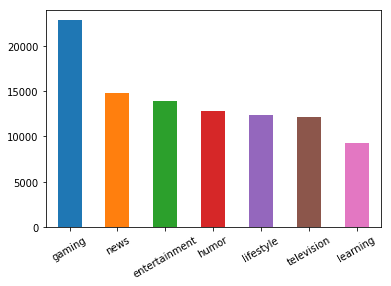

In [29]:
reddit.meta.value_counts().plot.bar()
plt.xticks(rotation=30)

# Feature engineering

### Number of links in the comment

In [140]:
reddit['num_link'] = reddit['text'].str.count('http') + reddit['text'].str.count('https')

In [13]:
# Now remove all the links out of the text


In [106]:
# # p_link = re.compile("https? : //([\w_-]+(?:(?:\.[\w_-]+)+)([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-]*))?")
# p_link = re.compile('(https? : \/\/)(\s)?(www\.)?(\s?)(\w+\.)*([\w\-\s]+\/)*([\w-]+)+\/?\s?')


In [137]:
# text = "easonable : http : //www.nytimes.com/1987/11/12/us/reagan-nominates-anthony-kennedy-to-supreme-court.html ? pagewanted = all equally ridiculous , here 's a 1970 law review article in which mcconnell argues for presidential dominion in the supreme court nomination process http : //imgur.com/pbeveod"
# result = p_link.findall(text)
# print(result)

[('http : //', '', 'www.', '', 'nytimes.', 'us/', 'reagan-nominates-anthony-kennedy-to-supreme-court'), ('http : //', '', '', '', 'imgur.', 'com/', 'pbeveod')]


In [112]:
# for element in result[0]:
#     text = text.replace(element, '')
# text

"easonable : com/1987/11/12/.html ? pagewanted = all equally ridiculous , here 's a 1970 law review article in which mcconnell argues for presidential dominion in the supreme court nomination process imgur.com/pbeveod"

In [122]:
# text.replace(':','')
# text

"easonable : com/1987/11/12/.html ? pagewanted = all equally ridiculous , here 's a 1970 law review article in which mcconnell argues for presidential dominion in the supreme court nomination process imgur.com/pbeveod"

### Word count

In [141]:
# remove punctuations
reddit.text = reddit.text.str.replace('[.,?!;:]', '')

In [142]:
reddit['word_count'] = reddit['text'].str.split().str.len()

In [143]:
reddit.word_count.max()

10000

(array([1.400e+01, 1.627e+03, 2.377e+03, ..., 0.000e+00, 0.000e+00,
        1.000e+00]),
 array([0.000e+00, 1.000e+00, 2.000e+00, ..., 9.998e+03, 9.999e+03,
        1.000e+04]),
 <a list of 10000 Patch objects>)

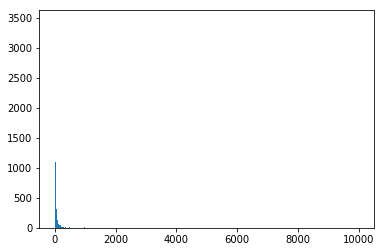

In [20]:
plt.hist(x=reddit['word_count'], bins=10000)

__Note__: Most comments seem to have less than 400 words but there are some dubiously long comments. --> Outliers to remove. Will treat them separately.

In [147]:
reddit_long = reddit[reddit.word_count >= 400]
reddit = reddit[reddit.word_count < 400]

(array([7.3080e+03, 1.2709e+04, 1.2746e+04, 1.0361e+04, 8.1420e+03,
        6.2430e+03, 5.0490e+03, 3.9790e+03, 3.3070e+03, 2.6230e+03,
        2.5120e+03, 1.9680e+03, 1.6800e+03, 1.5320e+03, 1.3740e+03,
        1.2100e+03, 1.1010e+03, 1.0960e+03, 9.0300e+02, 7.1100e+02,
        6.7400e+02, 6.4800e+02, 5.9800e+02, 5.2200e+02, 4.3500e+02,
        4.3300e+02, 4.0000e+02, 4.1500e+02, 3.3200e+02, 2.6600e+02,
        3.3000e+02, 3.0800e+02, 2.5700e+02, 1.9900e+02, 2.6000e+02,
        2.4500e+02, 2.2600e+02, 2.1700e+02, 1.9400e+02, 1.9100e+02,
        1.8000e+02, 1.6100e+02, 1.4300e+02, 1.4400e+02, 1.1300e+02,
        1.3700e+02, 1.1700e+02, 1.6200e+02, 9.4000e+01, 8.7000e+01,
        8.0000e+01, 7.7000e+01, 7.6000e+01, 8.8000e+01, 5.8000e+01,
        6.1000e+01, 6.5000e+01, 6.4000e+01, 7.2000e+01, 6.8000e+01,
        5.8000e+01, 5.8000e+01, 4.3000e+01, 6.7000e+01, 5.6000e+01,
        4.9000e+01, 3.6000e+01, 7.5000e+01, 5.4000e+01, 5.6000e+01,
        3.4000e+01, 3.7000e+01, 5.4000e+01, 4.30

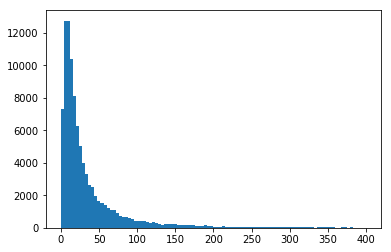

In [22]:
plt.hist(x=reddit['word_count'], bins=100)

### Word count categorical
Based on this distribution, we'll discretize comments based on word count into 4 groups: short, medium, long, and very long comments.

In [154]:
bins=[-1, 25, 50, 100, 500]
reddit['word_count_cat'] = pd.cut(reddit['word_count'], bins, labels=['short', 'medium', 'long', 'very long'])

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

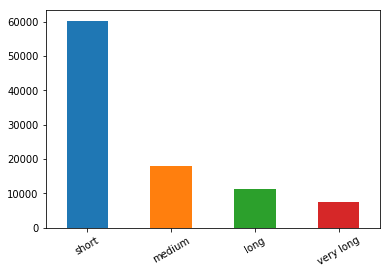

In [155]:
reddit.word_count_cat.value_counts().plot.bar()
plt.xticks(rotation=30)

### Subjectivity

In [158]:
reddit['subjectivity'] = reddit['text'].str.count('i ')

__Question__: Why are weird duplicates that `drop_duplicates` couldn't get rid of?

In [26]:
# reddit = reddit.drop_duplicates()

In [31]:
reddit[reddit.subjectivity == 32]  # why same comment but 4 records of different numbers of upvotes?

,text,id,subreddit,meta,time,author,ups,downs,authorlinkkarma,authorkarma,authorisgold,num_link,word_count,word_count_cat,subjectivity
415682,my journey began on april 4 2015 i had extrem...,d00rve2,progresspics,lifestyle,1.455554e+09,SwinginCrabWhacka,32.0,0.0,566.0,15176.0,0.0,0,351,"(100, 400]",32
472125,my journey began on april 4 2015 i had extrem...,d00rve2,progresspics,lifestyle,1.455554e+09,SwinginCrabWhacka,33.0,0.0,566.0,15176.0,0.0,0,351,"(100, 400]",32
574945,my journey began on april 4 2015 i had extrem...,d00rve2,progresspics,lifestyle,1.455554e+09,SwinginCrabWhacka,35.0,0.0,566.0,15176.0,0.0,0,351,"(100, 400]",32
649423,my journey began on april 4 2015 i had extrem...,d00rve2,progresspics,lifestyle,1.455554e+09,SwinginCrabWhacka,31.0,0.0,566.0,15176.0,0.0,0,351,"(100, 400]",32


(array([7.8739e+04, 8.8370e+03, 3.8030e+03, 2.0970e+03, 1.1450e+03,
        7.4000e+02, 4.0900e+02, 3.2200e+02, 2.0800e+02, 1.4300e+02,
        1.5300e+02, 9.5000e+01, 1.1100e+02, 7.6000e+01, 4.2000e+01,
        9.2000e+01, 1.9000e+01, 1.6000e+01, 3.2000e+01, 9.0000e+00,
        2.0000e+01, 1.3000e+01, 5.0000e+00, 2.0000e+00, 6.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 4.0000e+00]),
 array([ 0.        ,  1.06666667,  2.13333333,  3.2       ,  4.26666667,
         5.33333333,  6.4       ,  7.46666667,  8.53333333,  9.6       ,
        10.66666667, 11.73333333, 12.8       , 13.86666667, 14.93333333,
        16.        , 17.06666667, 18.13333333, 19.2       , 20.26666667,
        21.33333333, 22.4       , 23.46666667, 24.53333333, 25.6       ,
        26.66666667, 27.73333333, 28.8       , 29.86666667, 30.93333333,
        32.        ]),
 <a list of 30 Patch objects>)

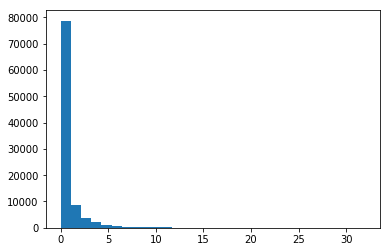

In [29]:
plt.hist(reddit.subjectivity, bins=30)

### Number of unique words

# Numericalize data

In [159]:
all_col = set(reddit.columns)
print(all_col) 
print(f"\nNumber of columns in the dataframe: {len(all_col)}")

{'meta', 'author', 'id', 'subreddit', 'authorlinkkarma', 'word_count_cat', 'downs', 'authorkarma', 'time', 'subjectivity', 'ups', 'authorisgold', 'text', 'word_count', 'num_link'}

Number of columns in the dataframe: 15


In [161]:
# Categorical variables
categ_variables = ['subreddit','meta', 'time', 'author', 'ups', 
                 'authorlinkkarma', 'authorkarma', 'authorisgold', 'word_count_cat']

# Excluded variables
excluded_variables = ['id', 'author', 'ups', 'downs']  # ups is the response variable, downs is trivial
len(categ_variables), len(excluded_variables)

(9, 4)

In [162]:
# Numerical variables
num_variables = list(all_col.difference(set(categ_variables).union(set(excluded_variables))))
num_variables = num_variables[1:]
num_variables

['subjectivity', 'num_link', 'word_count']

### Vectorize `text`

In [163]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(reddit['text'])

### Numericalize categorical variables

In [164]:
encoder = DictVectorizer()
X_categ = encoder.fit_transform(reddit[categ_variables].to_dict('records'))

# Model fitting

In [165]:
y = reddit.ups
x = hstack([X_tfidf, X_categ, reddit[num_variables]])

### Split into a test set and a training set

In [166]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

## Linear Regression

In [167]:
lm_model = LinearRegression()

In [169]:
reddit.describe()

,time,ups,downs,authorlinkkarma,authorkarma,authorisgold,num_link,word_count,subjectivity
count,9.711900e+04,97119.000000,97119.0,9.711900e+04,9.711900e+04,87835.000000,97119.000000,97119.000000,97119.000000
mean,1.455398e+09,52.930261,0.0,5.044801e+03,1.749696e+04,0.089156,0.189448,35.591645,0.906620
std,1.672372e+06,258.156817,0.0,5.950061e+04,6.155876e+04,0.284970,1.130853,49.672784,1.844877
min,1.400892e+09,-164.000000,0.0,0.000000e+00,-1.000000e+02,0.000000,0.000000,0.000000,0.000000
25%,1.455560e+09,1.000000,0.0,1.000000e+00,3.280000e+02,0.000000,0.000000,9.000000,0.000000
50%,1.455629e+09,4.000000,0.0,1.050000e+02,2.907000e+03,0.000000,0.000000,18.000000,0.000000
75%,1.455656e+09,16.000000,0.0,1.475000e+03,1.345900e+04,0.000000,0.000000,40.000000,1.000000
max,1.455688e+09,5656.000000,0.0,5.650077e+06,2.220594e+06,1.000000,60.000000,399.000000,32.000000


In [168]:
lm_model.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').